In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [10]:
inspector.get_table_names()

['measurement', 'station']

In [11]:
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

last_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.

one_year = dt.date(last_date.year -1, last_date.month, last_date.day)

# Perform a query to retrieve the data and precipitation scores

sel = [Measurement.date, Measurement.prcp]
data = session.query(*sel).filter(Measurement.date >= one_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation_df = pd.DataFrame(data, columns = ['Date', 'Precipitation'])
precipitation_df = precipitation_df.set_index('Date')

# Sort the dataframe by date

precipitation_df.sort_values(['Date'])
precipitation_df.head()

,Precipitation
Date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00


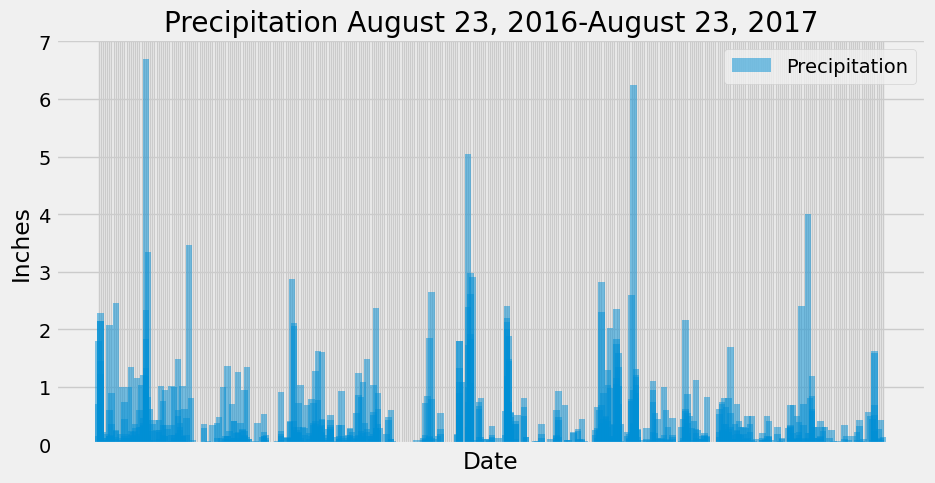

In [23]:
# Use Pandas Plotting with Matplotlib to plot the data
x = precipitation_df.index
y = precipitation_df['Precipitation']

plt.figure(figsize = (10, 5))
plt.bar(x,y, width = 3, alpha = 0.5, label = "Precipitation")
plt.title('Precipitation August 23, 2016-August 23, 2017')
plt.tick_params(bottom = False, labelbottom = False)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.legend(loc = 'best')
plt.savefig('..\SurfsUp\precipitation.png')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
num_stations = session.query(Station).group_by(Station.name).count()
num_stations

9

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.id))\
                                .group_by(Measurement.station)\
                                .order_by(func.count(Measurement.id).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

most_active_data = session.query(*sel).filter(Measurement.station.in_(['USC00519281'])).all()

most_active_data

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

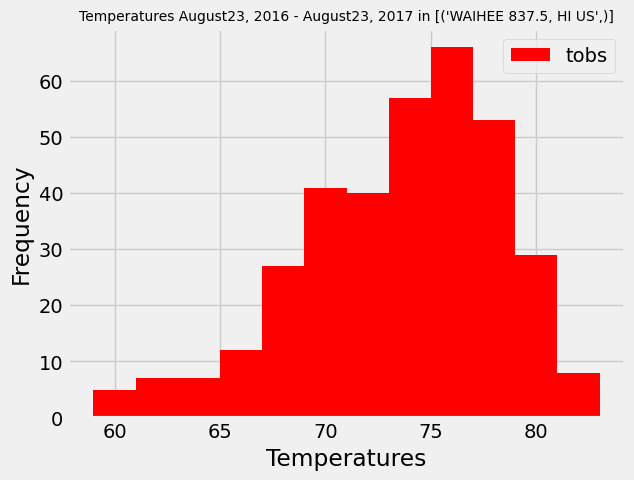

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

last_12_months = session.query(Measurement.date, Measurement.tobs).filter(Measurement.date >= one_year)\
                            .filter(Measurement.station.in_(['USC00519281'])).all()

station_name = session.query(Station.name).filter(Station.station.in_(['USC00519281'])).all()
station_name

active_station_df = pd.DataFrame(last_12_months, columns = ['Date', 'Temperatures'])

active_station_df.head()

x = active_station_df['Date']
y = active_station_df['Temperatures']
plt.hist(y, bins = 12, color = 'r', label = 'tobs')
plt.title(f'Temperatures August23, 2016 - August23, 2017 in {station_name}', size = 10)
plt.xlabel('Temperatures')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close session

In [ ]:
# Close Session
session.close()